Целью работы является разработка и исследование нейросети для прогнозирования рейтинга фильма по его характеристикам

Для достижения цели необходимо:

1. Провести анализ и предобработку данных (очистку, нормализацию, кодирование категориальных признаков);
2. Построить baseline-модель нейронной сети;
3. Реализовать подбор гиперпараметров и оценить влияние активации, dropout, batch normalization и размера батча на качество модели;
4. Сравнить результаты и выбрать оптимальные параметры по метрике RMSE.

# 1. Анализ и предобработка

## Загрузка данных и соединение

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Копия mkrf_movies.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Копия mkrf_shows.csv')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Чтобы объединить датасеты по puNumber, нужно привести их в один тип

In [ ]:
df1['puNumber'] = df1['puNumber'].astype(str)
df2['puNumber'] = df2['puNumber'].astype(str)

In [ ]:
df = pd.merge(df1, df2, on='puNumber', how='left')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Пропуски во всех колонках кроме первых четырех и age_restriction

## Обработка дубликатов

Сначала хочу попробовать убрать частичные дубликаты, что поможет избавиться от лишних данных

In [ ]:
subset_columns = ['title', 'type', 'production_country', 'age_restriction', 'producer', 'ratings']
duplicates_part = df[df.duplicated(subset=subset_columns, keep=False)]
duplicates_part = duplicates_part[duplicates_part['ratings'].notna()]
duplicates_part.head(5)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
12,Малышка на миллион /По мотивам рассказов Ф.Х.Т...,221011415,2015-04-03T12:00:00.000Z,Художественный,"Уорнер Бразерс, Лейкшор Интертейнмент, Малпасо...",США,Клинт Иствуд,"Клинт Иствуд, Том Розенберг, Альберт С.Рудди, ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,8.1,"драма,спорт",NaN
26,Оружейный барон,221012515,2015-04-03T12:00:00.000Z,Художественный,"Вэ И Пэ Медиенфондс 3, Асендант Пикчерз, Сатур...",США - Франция - Турция,Эндрю Никкол,"Норман Голуайтли, Энди Грош, Николас Кейдж, Эн...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.7,"боевик,драма,криминал",NaN


In [ ]:
new_df = df.copy()
new_df = new_df.drop_duplicates(subset=subset_columns, keep='first')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6823 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  6823 non-null   object 
 1   puNumber               6823 non-null   object 
 2   show_start_date        6823 non-null   object 
 3   type                   6823 non-null   object 
 4   film_studio            6806 non-null   object 
 5   production_country     6821 non-null   object 
 6   director               6814 non-null   object 
 7   producer               6264 non-null   object 
 8   age_restriction        6823 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                5864 non-null   object 
 14  genres                 5855 non-null   object 
 15  box_offic

Посмотрим еше есть такие частичные дубликаты по названию фильма и дате релиза

In [ ]:
new_df['show_start_date'] = pd.to_datetime(new_df['show_start_date'])
subset_columns1 = ['title', 'show_start_date']
duplicates_part1 = new_df[new_df.duplicated(subset=subset_columns1, keep=False)]
duplicates_part1 = duplicates_part1[duplicates_part1['ratings'].notna()]
duplicates_part1

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


Нет таких наблюдений, значит, ничего не удаляем больше

## Обработка пропусков

Посмотрим колонки refundable_support, nonrefundable_support, budget, financing_source, в которых меньше всего значений

In [ ]:
columns_of_interest = ['refundable_support', 'nonrefundable_support', 'budget', 'financing_source']
filtered_df = new_df[new_df[columns_of_interest].notna().all(axis=1)]
filtered_df.head(5)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1281,Пока еще жива,111005313,2013-10-11 12:00:00+00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.0,26500000.0,79411900.0,Министерство культуры,8.1,"драма,мелодрама",365353.6
1448,Бесславные придурки,111003314,2014-03-28 12:00:00+00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.0,26000000.0,37142857.0,Министерство культуры,NaN,NaN,28140.0
1498,Невидимки,111004213,2013-09-10 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.0,107847945.0,176023490.0,Фонд кино,5.3,"комедия,фантастика",19957031.5
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.0,28000000.0,40574140.0,Министерство культуры,4.2,драма,55917.5
1792,Братья Ч,111004414,2014-04-23 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.0,25000000.0,40015122.0,Министерство культуры,6.4,драма,232100.0


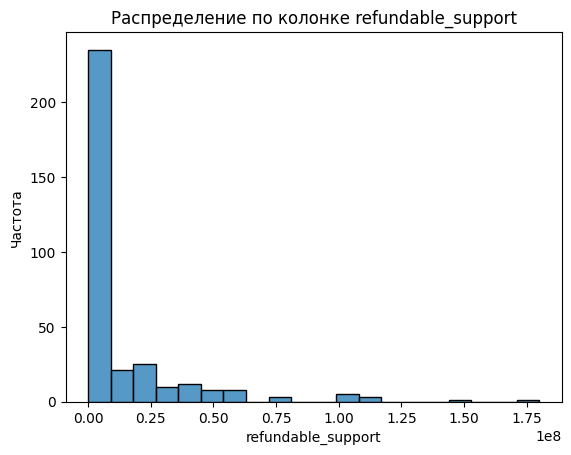

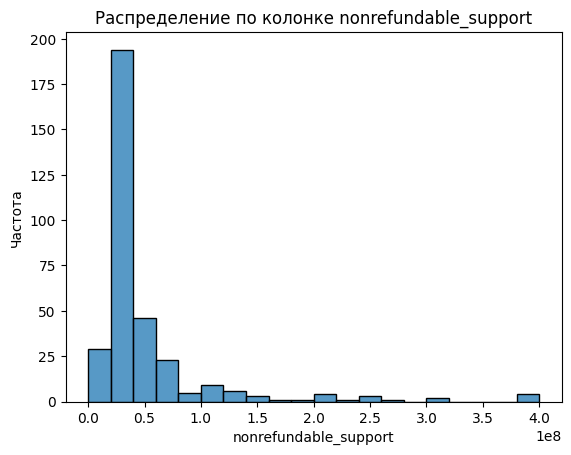

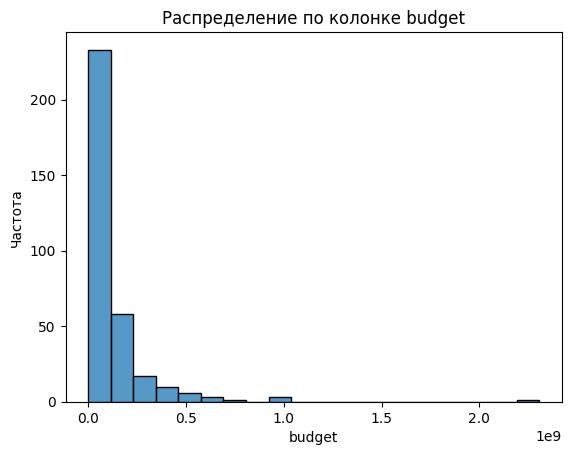

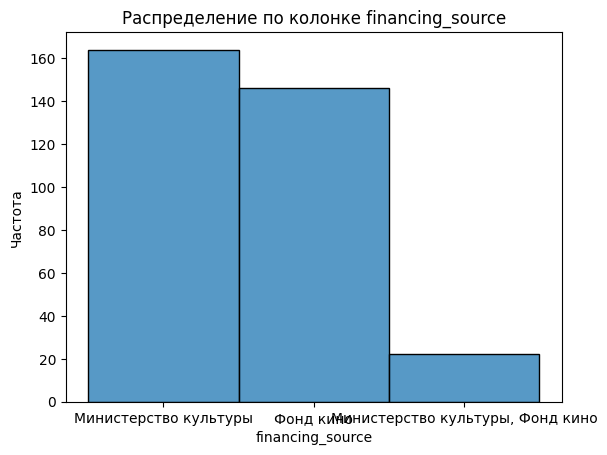

In [ ]:
for col in columns_of_interest:
    plt.figure()
    sns.histplot(filtered_df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.title(f'Распределение по колонке {col}')
    plt.show()

Распределения показывают, что большинство численных значений очень малы (ближе к нулю). Думаю, можно эти колонки заполнить нулем, потому что в основном эти колонки заполнены у российских фильмах, и, например, нам не известна государственная поддержка США

А пропуски в financing_source заполним "unknown"

In [ ]:
numeric_cols = ['refundable_support', 'nonrefundable_support', 'budget']
for col in numeric_cols:
    new_df[col] = new_df[col].fillna(0)

new_df['financing_source'] = new_df['financing_source'].fillna('unknown')

Посмотрим в каких колонках еще остались пропуски

In [ ]:
new_df.isna().sum()

,0
title,0
puNumber,0
show_start_date,0
type,0
film_studio,17
production_country,2
director,9
producer,559
age_restriction,0
refundable_support,0


Обработаем сначала те, в которых мало пропусков

Начнем с production_country

In [ ]:
production_country_nan = new_df[new_df['production_country'].isnull()]
production_country_nan

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,4.0,"мультфильм,комедия",NaN


Эти фильмы российские, поставим production_country Россия

In [ ]:
index = [3186, 4441]
new_df.loc[index, 'production_country'] = new_df.loc[index, 'production_country'].fillna('Россия')
#проверка на то, что пропусков больше нет в этой колонке
new_df['production_country'].isna().sum()

np.int64(0)

Посмотрим есь ли еще такой мульт личности, чтоб решить насчет заполнения пропусков

In [ ]:
mask = new_df['title'].astype(str).str.contains('личности', na=False)

mask_rows = new_df[mask]
mask_rows

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00+00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,4.0,"мультфильм,комедия",NaN


Других выпусков нет, значит вставим информацию из кинопоиска, а box_office пока оставим

In [ ]:
new_df.loc[4441, ['film_studio', 'director', 'producer']] = ['Concept Space / Prostranstvo Idey', 'В.Пичул, Ю.Владовский', 'К.Эрнст, М.Даниелян, Д.Либерман']

Рассмотрим пропуски в director

In [ ]:
director_nan = new_df[new_df['director'].isnull()]
director_nan

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00+00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00+00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00+00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00+00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,7.9,"концерт,музыка",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00+00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00+00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,6.7,"концерт,музыка",NaN


Заполним информацией из интернета

In [ ]:
new_df.loc[764, ['director']] = ['Ф.Хоф']
new_df.loc[1735, ['director']] = ['Д.Руни']
new_df.loc[3840, ['director']] = ['unknown']
new_df.loc[4052, ['director']] = ['unknown']
new_df.loc[4298, ['director']] = ['unknown']
new_df.loc[4415, ['director']] = ['unknown']
new_df.loc[4923, ['director']] = ['unknown']
new_df.loc[4942, ['director']] = ['Б.Лич']

Поставила unknown, потому что это запись концертов, как такового режиссера у них нет

Посмотрим film_studio

In [ ]:
film_studio_nan = new_df[new_df['film_studio'].isnull()]
film_studio_nan

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00+00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,0.0,0.0,0.0,unknown,7.3,комедия,NaN
6105,Значит любит,111013818,2018-08-10 12:00:00+00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,0.0,0.0,0.0,unknown,NaN,NaN,NaN
6181,Несейка. Младшая дочь,112007018,2018-09-01 12:00:00+00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
6379,Ян Антонышев,112011818,2018-11-15 12:00:00+00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00+00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,41225.0
6485,До и После,112014418,2018-12-05 12:00:00+00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,6.9,"драма,криминал,детектив",NaN
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05 12:00:00+00:00,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
6497,Мой папа Чингисхан,112014918,2018-12-06 12:00:00+00:00,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
6498,В плену города грёз,112014818,2018-12-06 12:00:00+00:00,Документальный,NaN,Россия,В.Витовцев,О.Мичи,«18+» - запрещено для детей,0.0,0.0,0.0,unknown,7.9,"фантастика,боевик,триллер",NaN
6499,Последнее фото,112014518,2018-12-06 12:00:00+00:00,Документальный,NaN,Россия,Е.Севастьянов,Е.Севастьянов,«18+» - запрещено для детей,0.0,0.0,0.0,unknown,NaN,NaN,NaN


In [ ]:
new_df.loc[1293, ['film_studio']] = ['Biscuit Pictures, Contemptible Entertainment, Mission Filmworks']
new_df.loc[6105, ['film_studio']] = ['unknown']
new_df.loc[6181, ['film_studio']] = ['Продюсерский центр «Молодежные инициативы»']
new_df.loc[6379, ['film_studio']] = ['unknown']
new_df.loc[6399, ['film_studio']] = ['unknown']
new_df.loc[6485, ['film_studio']] = ['unknown']
new_df.loc[6494, ['film_studio']] = ['unknown']
new_df.loc[6497, ['film_studio']] = ['unknown']
new_df.loc[6498, ['film_studio']] = ['unknown']
new_df.loc[6499, ['film_studio']] = ['unknown']
new_df.loc[6507, ['film_studio']] = ['unknown']
new_df.loc[6511, ['film_studio']] = ['ИП Дмитрий Кабаков, VFS FILMS']
new_df.loc[6638, ['film_studio']] = ['unknown']
new_df.loc[6639, ['film_studio']] = ['unknown']
new_df.loc[6662, ['film_studio']] = ['unknown']
new_df.loc[6722, ['film_studio']] = ['unknown']

unknown либо нет информации, либо без фильм студии снимали

In [ ]:
new_df.isna().sum()

,0
title,0
puNumber,0
show_start_date,0
type,0
film_studio,0
production_country,0
director,0
producer,558
age_restriction,0
refundable_support,0


Остались пропуски в четырех колонках: producer, ratings, genres и box_office

In [ ]:
producer_nan = new_df[new_df['producer'].isnull()]
producer_nan.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1,Особо важное задание,111013716,2016-09-13 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,6.6,"драма,военный",NaN
5,Остановился поезд,111013816,2016-09-13 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,7.7,драма,NaN
6,Любовь и голуби,111007013,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,8.3,"мелодрама,комедия",2700.0
9,Отпуск за свой счет,111019114,2014-12-01 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,7.8,"мелодрама,комедия",NaN
11,Ответный ход,111019014,2014-12-01 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,М.Туманишвили,NaN,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,7.8,"боевик,драма,приключения",NaN


In [ ]:
duplicate_count = new_df.duplicated(subset=['director', 'producer']).sum()
print(f"Количество дублирующихся строк по director и producer: {duplicate_count}")

Количество дублирующихся строк по director и producer: 554


In [ ]:
duplicate_count1 = new_df.duplicated(subset=['film_studio', 'producer']).sum()
print(f"Количество дублирующихся строк по film_studio и producer: {duplicate_count1}")

Количество дублирующихся строк по film_studio и producer: 904


Я хочу заполнить пропуски в producer так:
* если film_studio не unknown, то заполняем тем же значением из film_studio (раз дубликатов по film_studio больше в других наблюдениях)
* если film_studio unknown, а director не unknown, то заполняем тем же значением из director
* если film_studio и director unknown, то заполняем unknown

In [ ]:
new_df.loc[(new_df['producer'].isna()) & (new_df['film_studio'] != 'unknown'), 'producer'] = new_df['film_studio']

new_df.loc[(new_df['producer'].isna()) & (new_df['director'] != 'unknown'), 'producer'] = new_df['director']

new_df['producer'] = new_df['producer'].fillna('unknown')

#для проверки посмотрим те же строчки, что вывелись при producer_nan.head()
new_df.loc[[1, 5, 6, 9, 11]]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1,Особо важное задание,111013716,2016-09-13 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,"Киностудия ""Мосфильм""",«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,6.6,"драма,военный",NaN
5,Остановился поезд,111013816,2016-09-13 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,"Киностудия ""Мосфильм""",«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,7.7,драма,NaN
6,Любовь и голуби,111007013,2013-10-18 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,"Киностудия ""Мосфильм""",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,8.3,"мелодрама,комедия",2700.0
9,Отпуск за свой счет,111019114,2014-12-01 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,"Киностудия ""Мосфильм"", Телевидение ВНР",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,7.8,"мелодрама,комедия",NaN
11,Ответный ход,111019014,2014-12-01 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,М.Туманишвили,"Киностудия ""Мосфильм""",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,7.8,"боевик,драма,приключения",NaN


Теперь обработаем genres

In [ ]:
genres_nan = new_df[new_df['genres'].isnull()]
genres_nan

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
43,Мемуары гейши (по роману Артура Голдена),121000606,2012-12-14 12:00:00+00:00,Художественный,"Коламбия Пикчерз Корпорейшн, ДримУоркс ЭсКейДж...",США,Роб Маршалл,"Стивен Спилберг, Люси Фишер, Дуглас Уик, Джон ...",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
150,Жди меня,111013615,2015-08-25 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,"А.Столпер, Б.Иванов","Киностудия ""Мосфильм""",«6+» - для детей старше 6 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
154,Дом из песка и тумана (по книге Андре Дюбуи III),221037813,2013-10-25 12:00:00+00:00,Художественный,Кобальт Пикчерз,США,Вадим Перельман,Майкл Лондон,«16+» - для детей старше 16 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
159,Жемчужная девушка,224011014,2014-08-28 12:00:00+00:00,Художественный,"Чешское телевидение,Студия ""Три брата"" агентск...",Чехия,Владимир Дрга,"Чешское телевидение,Студия ""Три брата"" агентск...",«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,NaN
227,Полустанок,111026714,2014-12-24 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Б.Барнет,"Киностудия ""Мосфильм""",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7479,Эколав,111023219,2019-12-26 12:00:00+00:00,Художественный,ВГИК,Россия,Д.Григорьев,ВГИК,«18+» - запрещено для детей,0.0,0.0,0.0,unknown,NaN,NaN,NaN
7480,Акрам Хан: Родом из Карри Хауса,126007919,2019-12-23 12:00:00+00:00,Прочие,Свон Филмз,Великобритания,Ник Пойнц,"Поппи Бегум, Ник Пойнц",«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,219569.0
7481,Сад художника: Американский импрессионизм,126008019,2019-12-23 12:00:00+00:00,Прочие,Севен Артс Продакшнз,Великобритания,Фил Грабски,Фил Грабски,«12+» - для детей старше 12 лет,0.0,0.0,0.0,unknown,NaN,NaN,NaN
7483,Щенячий патруль: Скорей спешим на помощь!,124010819,2019-12-28 12:00:00+00:00,Художественный,"Никелодеон Анимейшн Студиос, Спин Мастер",США - Канада,Чарльз Е.Бастьен,Дженнифер Додж,«0+» - для любой зрительской аудитории,0.0,0.0,0.0,unknown,NaN,NaN,NaN


Посмотрим на тип фильма, чтобы попробовать определить жанр для фильмов

In [ ]:
genres_nan['type'].value_counts()

,count
type,
Анимационный,256
Художественный,215
Прочие,198
Художественный,157
Документальный,124
Научно-популярный,18


Нужно понять и обработать два вида "Художественный"

In [ ]:
genres_nan['type'].unique()

array(['Художественный', 'Прочие', 'Документальный', 'Анимационный',
       'Научно-популярный', ' Художественный'], dtype=object)

Отличаются пробелом в названии, изменим это в изначальном датасете (позже и другие значения обработаем также)

In [ ]:
new_df.loc[:, 'type'] = new_df['type'].replace({' Художественный': 'Художественный'})

В принципе для анимационных можно поставить жанр мультфильм, для докумнтальных - документальный, а для остальных - unknown

In [ ]:
new_df.loc[(new_df['genres'].isna()) & (new_df['type'] == 'Анимационный'), 'genres'] = 'мультфильм'

new_df.loc[(new_df['genres'].isna()) & (new_df['type'] == 'Документальный'), 'genres'] = 'документальный'

new_df['genres'] = new_df['genres'].fillna('unknown')

Остались две колонки с пропусками ratings и box_office

Заполним их таким образом, чтобы это были средние значения в соответствующих столбцах по группам страна (production_country), тип фильма (type), жанр (genres), возрастная категория (age_restriction). Например, чтоб рассчитывались средние значения ratings и box_office по тем наблюдениям, в которых в этих колонках нет пропусков,  страна Россия, тип фильма художественный, жанр драма, возрастная категория 18+

In [ ]:
df_filled = new_df.copy()

# Список столбцов, по которым будем группировать
group_cols = ['production_country', 'type', 'genres', 'age_restriction']

# Для каждого целевого столбца заполним пропуски средним по группе
for col in ['ratings', 'box_office']:
  df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')
  df_filled[col] = df_filled[col].fillna(df_filled.groupby(group_cols)[col].transform('mean'))

# Проверим, остались ли пропуски
print(df_filled[['ratings', 'box_office']].isna().sum())

ratings        666
box_office    2110
dtype: int64


Остались еще пропуски, попробуем группировку по стране и жанру

In [ ]:
# Список столбцов, по которым будем группировать
group_cols1 = ['production_country', 'genres']

# Для каждого целевого столбца заполним пропуски средним по группе
for col in ['ratings', 'box_office']:
  df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')
  df_filled[col] = df_filled[col].fillna(df_filled.groupby(group_cols1)[col].transform('mean'))

# Проверим, остались ли пропуски
print(df_filled[['ratings', 'box_office']].isna().sum())

ratings        427
box_office    1536
dtype: int64


Еще остались пропуски, попробуем группировку только по стране

In [ ]:
# Список столбцов, по которым будем группировать
group_cols2 = ['production_country']

# Для каждого целевого столбца заполним пропуски средним по группе
for col in ['ratings', 'box_office']:
  df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')
  df_filled[col] = df_filled[col].fillna(df_filled.groupby(group_cols2)[col].transform('mean'))

# Проверим, остались ли пропуски
print(df_filled[['ratings', 'box_office']].isna().sum())

ratings        91
box_office    445
dtype: int64


Попробуем группировку только по типу фильма

In [ ]:
# Список столбцов, по которым будем группировать
group_cols3 = ['type']

# Для каждого целевого столбца заполним пропуски средним по группе
for col in ['ratings', 'box_office']:
  df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')
  df_filled[col] = df_filled[col].fillna(df_filled.groupby(group_cols3)[col].transform('mean'))

# Проверим, остались ли пропуски
print(df_filled[['ratings', 'box_office']].isna().sum())

ratings       0
box_office    0
dtype: int64


In [ ]:
df_filled.isna().sum()

,0
title,0
puNumber,0
show_start_date,0
type,0
film_studio,0
production_country,0
director,0
producer,0
age_restriction,0
refundable_support,0


## Обработка колонок type, production_country и genres

Посмотрим уникальные значения по столбцам type, production_country и genres, чтобы обработать дубликаты с пробелами или другие проблемы

In [ ]:
u = df_filled.apply(lambda x: x.unique())
u['type']

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Анимационный', 'Музыкально-развлекательный'],
      dtype=object)

In [ ]:
df_filled.loc[:, 'type'] = df_filled['type'].replace({' Анимационный': 'Анимационный'})

Колонка type обработана от дубликатов

Перейдем к странам

In [ ]:
u['production_country']

array(['США', 'СССР', 'Франция', 'СССР, Венгрия',
       'Германия-Великобритания', 'Великобритания - Италия',
       'Чехословакия', 'США - Франция - Турция', 'Новая Зеландия',
       'Канада - Франция - Испания', 'США-Германия',
       'США - Великобритания', 'Великобритания', 'США - Германия',
       'Франция - Мексика - США', 'Россия, Казахстан, США',
       'СССР, Швеция', 'СССР, Франция, Англия, Куба, ГДР', 'Германия',
       'Великобритания-США-Германия-КНР',
       'СССР, ЧССР, Западный Берлин, ПНР', 'СССР, Италия', 'Гонконг, КНР',
       'США - Франция', 'США - Япония - Франция - Великобритания',
       'Гонконг - Сингапур - Таиланд - Великобритания', 'США-Канада',
       'Франция - Италия - Великобритания - США', 'Франция - США',
       'Ирландия-Великобритания-Германия', 'Чехия', 'США-Австралия',
       'СССР, Финляндия', 'США-Франция-Великобритания-Австрия',
       'США - Бельгия', 'США - Ирландия - Великобритания',
       'Великобритания - США',
       'Люксембург - Нидерл

Не похоже по некоторым наблюдениям, что страны записаны в алфавитном порядке, так что оставим в колонке только первую страну

In [ ]:
#сделаем все строчными для начала
df_filled['production_country'] = df_filled['production_country'].str.lower()

df_filled['first_country'] = df_filled['production_country'].apply(lambda x: x.split(',')[0].split('-')[0].split(' -')[0].strip())

In [ ]:
u_country = df_filled.apply(lambda x: x.unique())
u_country['first_country']

array(['сша', 'ссср', 'франция', 'германия', 'великобритания',
       'чехословакия', 'новая зеландия', 'канада', 'россия', 'гонконг',
       'ирландия', 'чехия', 'люксембург', 'япония', 'аргентина', 'дания',
       'австрия', 'италия', 'кнр', 'швеция', 'испания', 'мексика',
       'бразилия', 'чили', 'австралия', 'португалия', 'исландия',
       'южная корея', 'бельгия', 'украина', 'босния и герцеговина',
       'норвегия', 'швейцария', 'греция', 'норвения', 'грузия',
       'финляндия', 'израиль', 'иран', 'нидерланды',
       'республика узбекистан', 'турция', 'сербия', 'киргизия', 'индия',
       'польша', 'армения', 'юар', 'республика беларусь', 'румыния',
       'болгария', 'индонезия', 'таиланд', 'малайзия', 'азербайджан',
       'парагвай', 'уругвай', 'сща', 'хорватия', 'венгрия', 'эстония',
       'венесуэла', 'македония', 'республика кипр', 'перу', 'китай',
       'княжество андорра', 'республика казахстан', 'оаэ', 'корея',
       'голландия', 'литва', 'латвия', 'казахстан', '

Нужно обработать дубликаты США и Кореи (вряд ли у нас что-то из северной кореи показывают), а также посмотреть экземпляры с 2019

In [ ]:
df_filled.loc[:, 'first_country'] = df_filled['first_country'].replace({'cша': 'сша'})
df_filled.loc[:, 'first_country'] = df_filled['first_country'].replace({'сща': 'сша'})
df_filled.loc[:, 'first_country'] = df_filled['first_country'].replace({'республика корея': 'корея'})

In [ ]:
mask_country = df_filled['first_country'].astype(str).str.contains('2019', na=False)

mask_rows_country = df_filled[mask_country]
mask_rows_country

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_country
7247,Дело Коллини,121027219,2019-09-19 12:00:00+00:00,Художественный,"Константин Филм, Глобал Скрин, Севен Пикчерз Сван",2019,Марко Кройцпайнтнер,"Мартин Московиц, Кристоф Мюллер, Марсель Хартг...",«16+» - для детей старше 16 лет,0.0,0.0,0.0,unknown,7.4,"детектив,драма,криминал",7.490431e+07,2019


Из информации кинопоиска, это фильм Германии

In [ ]:
df_filled.loc[:, 'first_country'] = df_filled['first_country'].replace({'2019': 'германия'})

#удалим заодно ненужный уже столбец production_country
df_filled.drop('production_country', axis=1, inplace=True)

Колонка со странами обработана

Перейдем к жанрам

In [ ]:
u['genres']

array(['боевик,драма,мелодрама', 'драма,военный',
       'фантастика,боевик,триллер', 'драма', 'мелодрама,комедия',
       'мюзикл,мелодрама,комедия', 'комедия,криминал',
       'боевик,триллер,детектив', 'боевик,драма,приключения',
       'драма,спорт', 'триллер,драма,мелодрама', 'комедия,мелодрама',
       'драма,мелодрама,комедия', 'драма,мелодрама', 'драма,история',
       'драма,мелодрама,семейный', 'комедия,мелодрама,криминал',
       'комедия', 'боевик,драма,криминал', 'драма,комедия',
       'ужасы,фантастика,комедия', 'мультфильм,короткометражка,мелодрама',
       'драма,криминал', 'мультфильм,фантастика,фэнтези',
       'триллер,драма,криминал', 'драма,мелодрама,биография',
       'драма,комедия,военный', 'фантастика,драма,детектив',
       'мюзикл,семейный', 'unknown', 'военный,приключения,драма',
       'документальный,драма', 'драма,биография,история',
       'боевик,триллер,драма', 'фэнтези,боевик',
       'боевик,комедия,криминал', 'мюзикл,комедия,детский',
       'комед

Также оставим только первое наблюдение

In [ ]:
#сделаем все строчными для начала
df_filled['genres'] = df_filled['genres'].str.lower()

df_filled['first_genre'] = df_filled['genres'].apply(lambda x: x.split(',')[0].strip())

In [ ]:
u_genre = df_filled.apply(lambda x: x.unique())
u_genre['first_genre']

array(['боевик', 'драма', 'фантастика', 'мелодрама', 'мюзикл', 'комедия',
       'триллер', 'ужасы', 'мультфильм', 'unknown', 'военный',
       'документальный', 'фэнтези', 'криминал', 'приключения', 'аниме',
       'детектив', 'для взрослых', 'семейный', 'концерт', 'история',
       'короткометражка', 'детский', 'спорт', 'биография', 'вестерн',
       'музыка', 'фильм-нуар', 'реальное тв'], dtype=object)

In [ ]:
df_filled.drop('genres', axis=1, inplace=True)

## Обработка age_restriction

In [ ]:
df_1 = df_filled.copy()
df_1['age_restriction'] = pd.to_numeric(df_1['age_restriction'].str.extract(r'(\d+)', expand=False))

In [ ]:
u_age = df_1.apply(lambda x: x.unique())
u_age['age_restriction']

array([18,  6, 12, 16,  0])

## Обработка колонки show_start_date

Создадим новые колонки: year, month, day_of_week

In [ ]:
df_1['year'] = df_1['show_start_date'].dt.year
df_1['month'] = df_1['show_start_date'].dt.month
df_1['day_of_week'] = df_1['show_start_date'].dt.day_name()

df_1.drop('show_start_date', axis=1, inplace=True)

Посмотрим какими данные у нас получились

In [ ]:
df_removed = df_1.copy()
df_removed

,title,puNumber,type,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,box_office,first_country,first_genre,year,month,day_of_week
0,Открытый простор,221048915,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",18,0.0,0.0,0.0,unknown,7.200000,1.458587e+08,сша,боевик,2015,11,Friday
1,Особо важное задание,111013716,Художественный,"Киностудия ""Мосфильм""",Е.Матвеев,"Киностудия ""Мосфильм""",6,0.0,0.0,0.0,unknown,6.600000,4.808000e+03,ссср,драма,2016,9,Tuesday
2,Особо опасен,221038416,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18,0.0,0.0,0.0,unknown,6.800000,7.011515e+08,сша,фантастика,2016,10,Monday
5,Остановился поезд,111013816,Художественный,"Киностудия ""Мосфильм""",В.Абдрашитов,"Киностудия ""Мосфильм""",6,0.0,0.0,0.0,unknown,7.700000,3.758158e+04,ссср,драма,2016,9,Tuesday
6,Любовь и голуби,111007013,Художественный,"Киностудия ""Мосфильм""",В.Меньшов,"Киностудия ""Мосфильм""",12,0.0,0.0,0.0,unknown,8.300000,2.700000e+03,ссср,мелодрама,2013,10,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,Сад художника: Американский импрессионизм,126008019,Прочие,Севен Артс Продакшнз,Фил Грабски,Фил Грабски,12,0.0,0.0,0.0,unknown,6.590016,2.195690e+05,великобритания,unknown,2019,12,Monday
7482,Звериная ярость,121037819,Художественный,"Дэниел Гродник Продакшнз, Вандерфилм Медиа Кор...",Ник Пауэлл,"Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэ...",16,0.0,0.0,0.0,unknown,5.400000,2.745176e+07,сша,боевик,2019,12,Tuesday
7483,Щенячий патруль: Скорей спешим на помощь!,124010819,Художественный,"Никелодеон Анимейшн Студиос, Спин Мастер",Чарльз Е.Бастьен,Дженнифер Додж,0,0.0,0.0,0.0,unknown,6.429032,1.224407e+08,сша,unknown,2019,12,Saturday
7484,"Машины песенки. Серия ""Испанские мотивы""",124010619,Анимационный,"Анимаккорд Лтд., ООО Студия ""АНИМАККОРД""",А.Беляев,Д.Ловейко,0,0.0,0.0,0.0,unknown,7.400000,7.639992e+07,республика кипр,мультфильм,2019,12,Monday


## Удаление ненужных признаков и добавление новых

На данном этапе по моему мнению для предсказания рейтинга фильма неинформативными колонками являются title (названия уникальны), puNumber (уникальный идентификатор), film_studio и producer (из колонок film_studio,director, producer только режиссер обычно привлекает внимание как воплотитель сценария в жизнь)

In [ ]:
df_removed.drop('title', axis=1, inplace=True)
df_removed.drop('puNumber', axis=1, inplace=True)
df_removed.drop('film_studio', axis=1, inplace=True)
df_removed.drop('producer', axis=1, inplace=True)

Добавим колонку "foreign", которая будет показывать русский фильм или зарубежный (это также отразит и студию производителя, которую мы удалили)

In [ ]:
russian_countries = ['ссср', 'россия']

df_removed['foreign'] = ~df_removed['first_country'].isin(russian_countries)

## Использование StandardScaler и кодирование категорий в индексы для дальнейшего преобразования в их векторы

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

numeric_features = [
    "age_restriction", "refundable_support", "nonrefundable_support",
    "budget", "box_office", "year", "month"
]
categorical_features = [
    "type", "director", "financing_source",
    "first_country", "first_genre", "day_of_week", 'foreign'
]

scaler = StandardScaler()
df_removed[numeric_features] = scaler.fit_transform(df_removed[numeric_features])

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_removed[col] = le.fit_transform(df_removed[col].astype(str))
    label_encoders[col] = le

# 2. Построение baseline-модели нейронной сети

## Подготовка

In [ ]:
from sklearn.model_selection import train_test_split

X = df_removed.drop(columns=['ratings'])
y = df_removed['ratings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Сделаем обертку исходных данных, в которой хранятся категориальные признаки в виде индексов, числовые признаки и целевое значение

In [ ]:
from torch.utils.data import Dataset
import torch

class MovieDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.X_cat = X[cat_cols].values.astype(np.int64)
        self.X_num = X[num_cols].values.astype(np.float32)
        self.y = y.values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_cat[idx]),
            torch.tensor(self.X_num[idx]),
            torch.tensor(self.y[idx])
        )

Преобразуем данные в формат Pytorch и сгенерируем батчи

In [ ]:
from torch.utils.data import DataLoader

train_ds = MovieDataset(X_train, y_train, categorical_features, numeric_features)
test_ds = MovieDataset(X_test, y_test, categorical_features, numeric_features)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

Подготовка размеров эмбеддингов для категориальных признаков

In [ ]:
embedding_sizes = [
    (df_removed[col].nunique(), min(50, (df_removed[col].nunique() // 2) + 1))
    for col in categorical_features
]

## Класс для архитектуры нейронной сети

In [ ]:
import torch.nn as nn

class RatingModel(nn.Module):
    def __init__(self, embedding_sizes, n_numeric):
        super().__init__()
        #векторное преобразование для категориальных признаков
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        self.embedding_dropout = nn.Dropout(0.1)  #регуляризация
        emb_dim_total = sum([size for _, size in embedding_sizes])

        #архитектура сети (3 скрытых слоя 256 - 128 - 64, активация ReLU, на выходе одно значение)
        self.fc = nn.Sequential(
            nn.Linear(emb_dim_total + n_numeric, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x_cat, x_num):
        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x = torch.cat(emb, dim=1)
        x = self.embedding_dropout(x)
        x = torch.cat([x, x_num], dim=1)
        return self.fc(x)

## Обучение

In [ ]:
from tqdm import tqdm

def train_model(model, train_dl, test_dl, epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()  #функция потерь среднеквадратичная ошибка
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #оптимизатор Adam

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_cat, x_num, y in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x_cat, x_num)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        preds_list, y_list = [], []
        with torch.no_grad():
            for x_cat, x_num, y in test_dl:
                x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
                preds = model(x_cat, x_num)
                preds_list.append(preds.cpu().numpy())
                y_list.append(y.cpu().numpy())

        preds_all = np.vstack(preds_list)
        y_all = np.vstack(y_list)
        rmse = np.sqrt(np.mean((preds_all - y_all) ** 2))
        print(f"Эпоха {epoch+1}: Функция потерь={np.mean(train_losses):.4f}, RMSE={rmse:.4f}")

    return model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RatingModel(embedding_sizes, n_numeric=len(numeric_features))
trained_model = train_model(model, train_dl, test_dl, epochs=10, lr=1e-3, device=device)

Epoch 1/10: 100%|██████████| 86/86 [00:01<00:00, 71.53it/s]


Эпоха 1: Функция потерь=6.2084, RMSE=1.1554


Epoch 2/10: 100%|██████████| 86/86 [00:00<00:00, 124.34it/s]


Эпоха 2: Функция потерь=1.1734, RMSE=1.1020


Epoch 3/10: 100%|██████████| 86/86 [00:00<00:00, 121.92it/s]


Эпоха 3: Функция потерь=1.0220, RMSE=1.0976


Epoch 4/10: 100%|██████████| 86/86 [00:00<00:00, 138.53it/s]


Эпоха 4: Функция потерь=0.9542, RMSE=1.0566


Epoch 5/10: 100%|██████████| 86/86 [00:00<00:00, 127.37it/s]


Эпоха 5: Функция потерь=0.8827, RMSE=1.1145


Epoch 6/10: 100%|██████████| 86/86 [00:00<00:00, 136.20it/s]


Эпоха 6: Функция потерь=0.8222, RMSE=1.1430


Epoch 7/10: 100%|██████████| 86/86 [00:00<00:00, 138.64it/s]


Эпоха 7: Функция потерь=0.7649, RMSE=1.0580


Epoch 8/10: 100%|██████████| 86/86 [00:00<00:00, 136.13it/s]


Эпоха 8: Функция потерь=0.7193, RMSE=1.0498


Epoch 9/10: 100%|██████████| 86/86 [00:00<00:00, 136.75it/s]


Эпоха 9: Функция потерь=0.6912, RMSE=1.0725


Epoch 10/10: 100%|██████████| 86/86 [00:00<00:00, 131.47it/s]

Эпоха 10: Функция потерь=0.6625, RMSE=1.1779


На протяжении 10 эпох обучения наблюдается снижение функции потерь и RMSE в первые 4 эпохи, что свидетельствует о прогрессе модели в обучении

Функция потерь уменьшилась с начального значения около 6.21 до 0.66 к концу тренировки. Но в последней эпохе произошла небольшая скачкообразная тенденция — RMSE немного увеличился по сравнению с предпоследней эпохой, что может указывать на некоторое переобучение

# Доработка модели

Преобразуем код, чтобы можно было менять параметры

In [ ]:
class RatingModel(nn.Module):
    def __init__(self, embedding_sizes, n_numeric, activation='ReLU', dropout=0.1, use_batchnorm=True):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size)for categories, size in embedding_sizes])
        self.embedding_dropout = nn.Dropout(dropout)
        emb_dim_total = sum([size for _, size in embedding_sizes])

        #активация
        act_layer = getattr(nn, activation)()

        layers = []
        input_dim = emb_dim_total + n_numeric
        hidden_sizes = [256, 128, 64]  #количество нейронов в слоях

        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act_layer)

            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            input_dim = h

        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.fc = nn.Sequential(*layers)

    def forward(self, x_cat, x_num):
        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x = torch.cat(emb, dim=1)
        x = self.embedding_dropout(x)
        x = torch.cat([x, x_num], dim=1)
        return self.fc(x)

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#функция обучения одной модели
def train_and_evaluate(model, train_ds, test_ds, batch_size, lr=1e-3, epochs=5, device='cpu'):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size*2, shuffle=False)

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for x_cat, x_num, y in train_dl:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x_cat, x_num)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

    #оценка RMSE
    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for x_cat, x_num, y in test_dl:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            preds = model(x_cat, x_num)
            preds_all.append(preds.cpu().numpy())
            y_all.append(y.cpu().numpy())

    preds_all = np.vstack(preds_all)
    y_all = np.vstack(y_all)

    return rmse(y_all, preds_all)

In [ ]:
import itertools

#сетка параметров
param_grid = {
    'activation': ['ReLU', 'LeakyReLU', 'ELU'],
    'dropout': [0.1, 0.3, 0.5],
    'use_batchnorm': [True, False],
    'batch_size': [16, 32, 64, 128],
}

#комбинации
param_combinations = list(itertools.product(
    param_grid['activation'],
    param_grid['dropout'],
    param_grid['use_batchnorm'],
    param_grid['batch_size']
))

Запуск grid search

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []

for activation, dropout, use_bn, batch_size in tqdm(param_combinations):
    model = RatingModel(embedding_sizes, len(numeric_features),
                        activation=activation,
                        dropout=dropout,
                        use_batchnorm=use_bn)
    score = train_and_evaluate(model, train_ds, test_ds, batch_size=batch_size, device=device)
    results.append({
        'activation': activation,
        'dropout': dropout,
        'batchnorm': use_bn,
        'batch_size': batch_size,
        'RMSE': score
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSE', inplace=True)
results_df.head(10)

100%|██████████| 72/72 [08:48<00:00,  7.34s/it]


,activation,dropout,batchnorm,batch_size,RMSE
54,ELU,0.1,False,64,0.989244
53,ELU,0.1,False,32,0.989743
50,ELU,0.1,True,64,1.004983
52,ELU,0.1,False,16,1.006145
49,ELU,0.1,True,32,1.007553
62,ELU,0.3,False,64,1.008388
25,LeakyReLU,0.1,True,32,1.009342
26,LeakyReLU,0.1,True,64,1.020970
68,ELU,0.5,False,16,1.032856
24,LeakyReLU,0.1,True,16,1.032864


В ходе подбора гиперпараметров методом было протестировано 72 комбинации

Наилучшее качество модели достигнуто при:

* функция ELU обеспечивает наилучшую сходимость и минимальную ошибку среди протестированных активаций;
* умеренный dropout (0.1) улучшает обобщающую способность сети;
* Batch Normalization незначительно влияет на результат и может быть опущен для упрощения модели;
* оптимальный batch size = 64, при котором достигается наилучший баланс между скоростью и качеством обучения.

In [ ]:
results_df.tail(5)

,activation,dropout,batchnorm,batch_size,RMSE
46,LeakyReLU,0.5,False,64,2.164212
43,LeakyReLU,0.5,True,128,2.193348
47,LeakyReLU,0.5,False,128,2.268219
19,ReLU,0.5,True,128,2.338447
67,ELU,0.5,True,128,2.922108


Диапазон RMSE от 0.989 до 2.922 показывает, что качество нейросети существенно зависит от гиперпараметров. При лучшей из рассмотренных настройках модель достигает высокой точности (0.989), что соответствует среднему отклонению менее одного пункта рейтинга

Но при неудачных комбинациях качество ухудшается до 2.922, что говорит о необходимости тонкой балансировки между регуляризацией и стабильностью обучения

То есть лучшая модель может ошибиться на 1 балл из 10 возможных в рейтинге

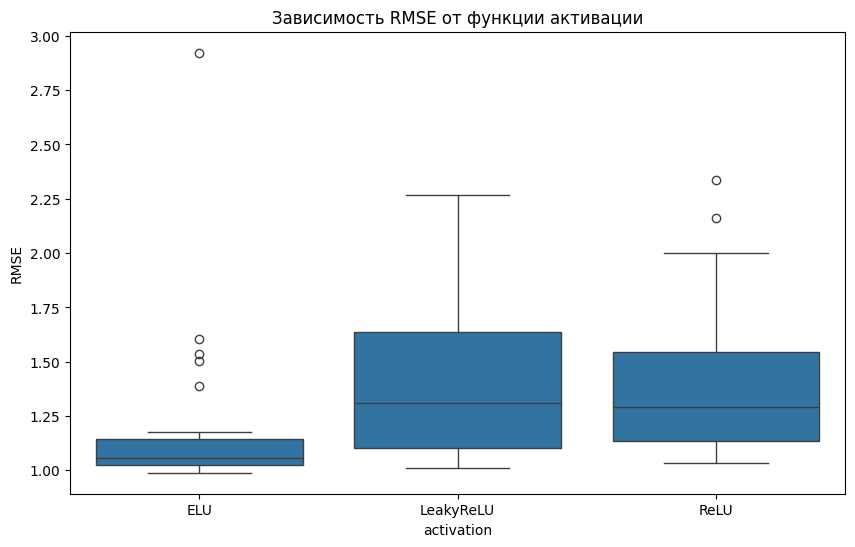

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=results_df, x='activation', y='RMSE')
plt.title("Зависимость RMSE от функции активации")
plt.show()

Функция ELU показывает наименьший разброс RMSE, что свидетельствует о более стабильных и точных результатах при ее использовании

LeakyReLU демонстрирует более широкий разброс RMSE, с некоторыми значениями значительно выше среднего, что указывает на большую вариативность результатов. Такой разброс ошибок может говорить о менее предсказуемой производительности

ReLU занимает промежуточное положение, с медианой выше и превышающим разбросом, чем у ELU, но меньшим разбросом, чем у LeakyReLU

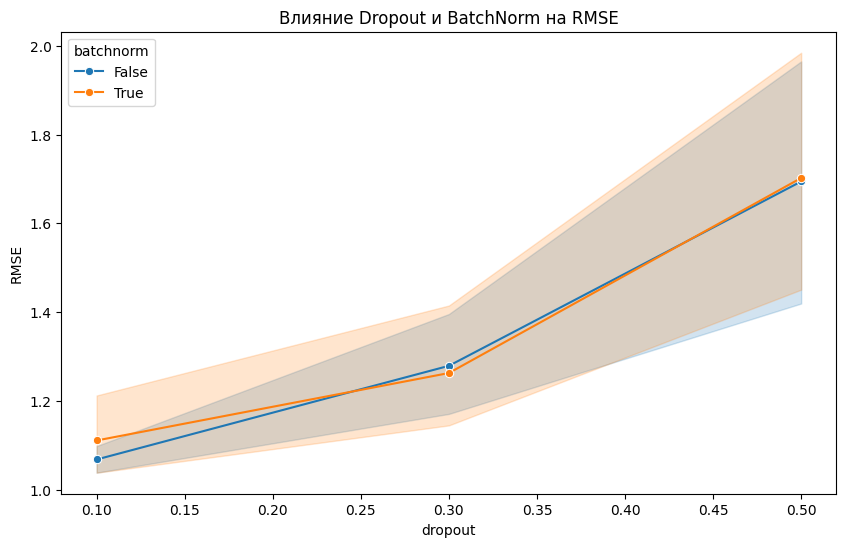

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x='dropout', y='RMSE', hue='batchnorm', marker='o')
plt.title("Влияние Dropout и BatchNorm на RMSE")
plt.show()

В обоих случаях с ростом dropout RMSE увеличивается, что говорит об обратной зависимости точности модели и dropout

В условиях отсутствия BatchNorm RMSE остается немного ниже и растет чуть медленнее по сравнению с его использованием. Это говорит о том, что BatchNorm в данном случае не способствует улучшению, а, наоборот, увеличивает ошибку при росте dropout

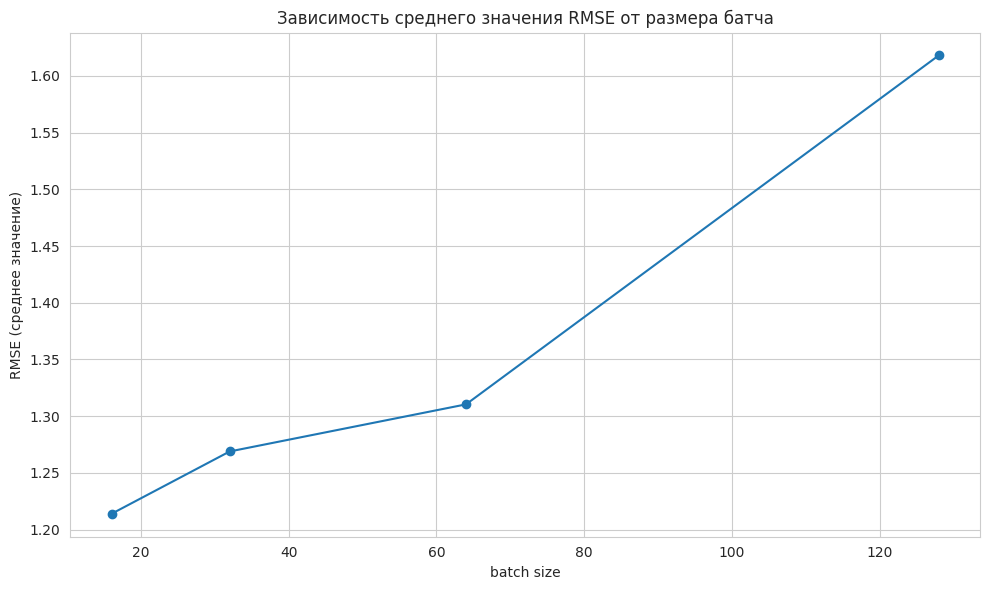

In [ ]:
mean_rmse_by_batch = results_df.groupby('batch_size')['RMSE'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(mean_rmse_by_batch['batch_size'], mean_rmse_by_batch['RMSE'], marker='o', linestyle='-')
plt.title("Зависимость среднего значения RMSE от размера батча")
plt.xlabel("batch size")
plt.ylabel("RMSE (среднее значение)")
plt.grid(True)
plt.tight_layout()
plt.show()

В начале, при размере батча 16, среднее RMSE составляет примерно 1.21. По мере увеличения размера батча до 32 и 64, среднее RMSE немного растет, достигая около 1.27 и 1.31 соответственно. Далее, при дальнейшем увеличении размера батча, среднее значение RMSE продолжает расти, достигая около 1.62 при батче 128

Общая тенденция показывает, что увеличение размера батча связано с ростом среднего RMSE, что может указывать на ухудшение качества модели или увеличение вариации ошибок при более больших батчах

# Выводы

Реализована нейронная сеть для предсказания рейтинга фильмов на основе их характеристик. Построена baseline-модель и проведен подбор гиперпараметров

Лучшие результаты достигнуты при использовании ELU-активации, dropout = 0.1 и batch size = 64 — при этом ошибка RMSE составила менее 1, что является хорошим результатом для baseline-уровня.

Полученные результаты показывают, что выбор функции активации и параметров регуляризации оказывает существенное влияние на точность нейросети